In [1]:
import os
import glob
import re
import random
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from collections import deque
from torch.utils.data import DataLoader

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [2]:
# def create_signed_sdf(grid):
#     """
#     맨해튼 거리 기반 Signed Distance Field (SDF)
#     - 경계면: 암석-공극 경계의 셀
#     - 거리는 경계면 셀의 중심부터 셀 중심까지의 Manhattan 거리 + 0.5
#     - 암석(m=0)은 +, 공극(m=1)은 -
#     """
#     rows, cols = grid.shape
#     seeds = []
#     dirs = [(-1,0),(1,0),(0,-1),(0,1)]
#     for i in range(rows):
#         for j in range(cols):
#             for di, dj in dirs:
#                 ni, nj = i+di, j+dj
#                 if 0 <= ni < rows and 0 <= nj < cols:
#                     if grid[ni, nj] != grid[i, j]:
#                         seeds.append((i, j))
#                         break
#     # BFS로 Manhattan 거리 계산
#     dist = np.full((rows, cols), -1, dtype=np.int32)
#     q = deque()
#     for (i, j) in seeds:
#         dist[i, j] = 0
#         q.append((i, j))
#     while q:
#         i, j = q.popleft()
#         for di, dj in dirs:
#             ni, nj = i+di, j+dj
#             if 0 <= ni < rows and 0 <= nj < cols and dist[ni, nj] == -1:
#                 dist[ni, nj] = dist[i, j] + 1
#                 q.append((ni, nj))
#     # sign mask: 암석(m=0)->+1, 공극(m=1)->-1
#     sign = np.where(grid == 0, 1.0, -1.0)
#     sdf = (dist.astype(np.float32) + 0.5) * sign
#     return sdf

from collections import deque
import numpy as np

def create_distance_map_from_pivots(grid, start_range=(None, None)):
    """
    grid: 2D numpy array, 통과 가능(1/2), 불가(0)
    start_range: 인렛 범위 (예: (28,36))
    반환값: 입구에서의 음수 거리 map (지나갈 수 없는 곳 0)
    """
    if grid is None or grid.size == 0:
        return np.array([])
    grid = grid.copy()
    rows, cols = grid.shape
    if start_range == (None, None):
        start_points = [(rows // 2, 0)]
    else:
        start_row, end_row = start_range
        start_points = [(i, 0) for i in range(start_row, end_row)]
    valid_starts = [pt for pt in start_points if grid[pt[0], pt[1]] in (1, 2)]
    distance_map = np.zeros((rows, cols), dtype=np.int32)  # 초기값을 0으로!
    if not valid_starts:
        return distance_map
    queue = deque([(pt, 0) for pt in valid_starts])
    visited = {pt for pt in valid_starts}
    directions = [(-1, 0), (0, 1), (1, 0), (0, -1)]
    while queue:
        (curr_row, curr_col), dist = queue.popleft()
        # **방문한 곳만 음수로 거리 부여 (멀수록 더 작은 음수)**
        if distance_map[curr_row, curr_col] == 0 or dist < -distance_map[curr_row, curr_col]:
            distance_map[curr_row, curr_col] = -dist
        for dx, dy in directions:
            new_row, new_col = curr_row + dx, curr_col + dy
            if (0 <= new_row < rows and 0 <= new_col < cols and 
                (new_row, new_col) not in visited and grid[new_row, new_col] in (1, 2)):
                queue.append(((new_row, new_col), dist + 1))
                visited.add((new_row, new_col))
    return distance_map


def get_normalized_Da(domain_num):
    """
    도메인 번호에 따른 Da 값을 MinMax 정규화
    (0.5, 2.0, 5.0) → [0, 1] 범위로 변환
    """
    if 1 <= domain_num <= 3000:
        orig_Da = 0.5
    elif 3001 <= domain_num <= 6000:
        orig_Da = 5.0
    elif 6001 <= domain_num <= 9000:
        orig_Da = 2.0
    else:
        raise ValueError("Domain number out of expected range")
    norm_Da = (orig_Da - 0.5) / 4.5
    return norm_Da

In [3]:
def load_concentration_data(npz_dir):
    """
    npz 폴더에서 m*.npz, A*.npz 파일을 불러와 도메인별 농도 데이터셋을 구성.
    - m: 마스크
    - A: 농도장
    """
    m_files = sorted(glob.glob(os.path.join(npz_dir, "m*.npz")),
                     key=lambda x: int(re.search(r"m(\d+)\.npz", os.path.basename(x)).group(1)))
    domain_data = []
    for m_file in m_files:
        m_match = re.search(r"m(\d+)\.npz", os.path.basename(m_file))
        if m_match is None:
            continue
        domain_num = int(m_match.group(1))
        A_file = os.path.join(npz_dir, f"A{domain_num}.npz")
        if not os.path.exists(A_file):
            continue

        with np.load(m_file) as data:
            m_flat = data['m']
            m_data = m_flat.reshape((64, 148))
            m_data = (m_data > 0.5).astype(int)   # <--- 이진화!

        with np.load(A_file) as data:
            A_flat = data['A']
            A_data = A_flat.reshape((64, 148))

        domain_data.append({
            'domain_num': domain_num,
            'm': m_data,
            'A': A_data
        })
    return domain_data

# def process_concentration_domain(domain_data, nx=64, ny=148):
#     """
#     하나의 도메인 데이터(dict)를 받아
#     - branch1_input: (1, nx, ny)  [mask image]
#     - branch2_input: (1,)         [norm_Da]
#     - trunk_input:   (1, nx*ny, 3) [x, y, sdf]
#     - target:        (nx, ny, 1)  (정규화 없이!)
#     - norm_params:   {}           (빈 dict)
#     """
#     domain_num = domain_data['domain_num']
#     m_data     = domain_data['m']
#     A_data     = domain_data['A']

#     # --- Branch 1: 마스크 이미지 ---
#     branch1_input = m_data.reshape((1, nx, ny))

#     # --- Branch 2: 정규화된 Da (스칼라) ---
#     norm_Da = get_normalized_Da(domain_num)
#     branch2_input = np.array([norm_Da], dtype=np.float32)  # shape (1,)

#     # --- Trunk: [x, y, sdf] ---
#     sdf = create_signed_sdf(m_data)
#     sdf_flat = sdf.flatten().astype(np.float32)
#     x_coords = np.arange(nx, dtype=np.float32)
#     y_coords = np.arange(ny, dtype=np.float32)
#     X, Y = np.meshgrid(x_coords, y_coords, indexing="ij")
#     x_flat = X.flatten()
#     y_flat = Y.flatten()
#     trunk_query = np.stack([x_flat, y_flat, sdf_flat], axis=1)  # (nx*ny, 3)
#     trunk_input = trunk_query[np.newaxis, ...]                  # (1, nx*ny, 3)

#     # --- Target: 농도 (정규화 X) ---
#     target = A_data.astype(np.float32)[..., np.newaxis]  # (nx, ny, 1)
#     norm_params = {}  # 사용 X

#     return domain_num, branch1_input, branch2_input, trunk_input, target, norm_params

# SDF2
def process_concentration_domain(domain_data, nx=64, ny=148, inlet_range=(None, None)):
    domain_num = domain_data['domain_num']
    m_data     = domain_data['m']
    A_data     = domain_data['A']

    branch1_input = m_data.reshape((1, nx, ny))
    norm_Da = get_normalized_Da(domain_num)
    branch2_input = np.array([norm_Da], dtype=np.float32)  # shape (1,)

    # 여기! SDF를 "인렛거리맵"으로 대체
    sdf = create_distance_map_from_pivots(m_data, start_range=inlet_range).astype(np.float32)
    # 보통 SDF는 0~1 정규화해서 트렁크에 넣으니 (원하면 생략 가능)
    sdf_min, sdf_max = sdf.min(), sdf.max()
    sdf_norm = (sdf - sdf_min) / (sdf_max - sdf_min + 1e-8)
    sdf_flat = sdf_norm.flatten().astype(np.float32)

    x_coords = np.arange(nx, dtype=np.float32)
    y_coords = np.arange(ny, dtype=np.float32)
    X, Y = np.meshgrid(x_coords, y_coords, indexing="ij")
    x_flat = X.flatten()
    y_flat = Y.flatten()
    trunk_query = np.stack([x_flat, y_flat, sdf_flat], axis=1)  # (nx*ny, 3)
    trunk_input = trunk_query[np.newaxis, ...]                  # (1, nx*ny, 3)

    target = A_data.astype(np.float32)[..., np.newaxis]  # (nx, ny, 1)
    norm_params = {'sdf_min': float(sdf_min),'sdf_max': float(sdf_max)}

    return domain_num, branch1_input, branch2_input, trunk_input, target, norm_params


# def build_concentration_dataset(domain_list, nx=64, ny=148):
#     """
#     여러 도메인 데이터를 받아
#     - branch1_list: (N, 1, nx, ny)
#     - branch2_list: (N, 1)
#     - trunk_list:   (N, 1, nx*ny, 3)
#     - target_list:  (N, nx, ny, 1)
#     - norm_params_list: (N, dict)
#     """
#     branch1_list, branch2_list, trunk_list, target_list, norm_params_list = [], [], [], [], []
#     for d in domain_list:
#         _, b1, b2, t, y, np_ = process_concentration_domain(d, nx, ny)
#         branch1_list.append(b1)
#         branch2_list.append(b2)
#         trunk_list.append(t)
#         target_list.append(y)
#         norm_params_list.append(np_)
#     return branch1_list, branch2_list, trunk_list, target_list, norm_params_list

# SDF 2용
def build_concentration_dataset(domain_list, nx=64, ny=148, inlet_range=(None, None)):
    branch1_list, branch2_list, trunk_list, target_list, norm_params_list = [], [], [], [], []
    for d in domain_list:
        _, b1, b2, t, y, np_ = process_concentration_domain(d, nx, ny, inlet_range)
        branch1_list.append(b1)
        branch2_list.append(b2)
        trunk_list.append(t)
        target_list.append(y)
        norm_params_list.append(np_)
    return branch1_list, branch2_list, trunk_list, target_list, norm_params_list



In [4]:
#############################################
# 3. 데이터셋 구성
#############################################
# (예시 경로) 농도 데이터가 저장된 폴더 경로
npz_dir = "/home/yehoon/npz/amv/npz_test"

# 1) 전체 도메인 로드
all_domains = load_concentration_data(npz_dir)
print("전체 도메인 수:", len(all_domains))

# 2) 도메인 그룹별 분할
group1 = [d for d in all_domains if 1 <= d['domain_num'] <= 3000]
group2 = [d for d in all_domains if 3001 <= d['domain_num'] <= 6000]
group3 = [d for d in all_domains if 6001 <= d['domain_num'] <= 9000]

random.seed(42)
def split_group(group, train_count=2700):
    random.shuffle(group)
    return group[:train_count], group[train_count:]

train_group1, test_group1 = split_group(group1, train_count=2700)
train_group2, test_group2 = split_group(group2, train_count=2700)
train_group3, test_group3 = split_group(group3, train_count=2700)

train_domains = train_group1 + train_group2 + train_group3
test_domains = test_group1 + test_group2 + test_group3

print("Train domains:", len(train_domains), "Test domains:", len(test_domains))

# 3) 전처리 함수 적용 (블록2에서 작성한 build_concentration_dataset)
train_b1_list, train_b2_list, train_t_list, train_y_list, train_norm_params = build_concentration_dataset(
    train_domains, nx=64, ny=148, inlet_range=(0,64)
)
test_b1_list, test_b2_list, test_t_list, test_y_list, test_norm_params = build_concentration_dataset(
    test_domains, nx=64, ny=148, inlet_range=(0,64)
)

# 4) torch tensor 변환
train_branch1_tensor = torch.tensor(np.stack(train_b1_list, axis=0), dtype=torch.float32)      # (N, 1, 64, 148)
train_branch2_tensor = torch.tensor(np.stack(train_b2_list, axis=0), dtype=torch.float32)      # (N, 1)
train_trunk_tensor   = torch.tensor(np.stack(train_t_list, axis=0), dtype=torch.float32)       # (N, 1, 64*148, 3)
train_target_tensor  = torch.tensor(np.stack(train_y_list, axis=0), dtype=torch.float32)       # (N, 64, 148, 1)

test_branch1_tensor = torch.tensor(np.stack(test_b1_list, axis=0), dtype=torch.float32)
test_branch2_tensor = torch.tensor(np.stack(test_b2_list, axis=0), dtype=torch.float32)
test_trunk_tensor   = torch.tensor(np.stack(test_t_list, axis=0), dtype=torch.float32)
test_target_tensor  = torch.tensor(np.stack(test_y_list, axis=0), dtype=torch.float32)

# 5) TensorDataset 생성 (3-input: branch1, branch2, trunk)
train_dataset = TensorDataset(train_branch1_tensor, train_branch2_tensor, train_trunk_tensor, train_target_tensor)
test_dataset  = TensorDataset(test_branch1_tensor, test_branch2_tensor, test_trunk_tensor, test_target_tensor)


전체 도메인 수: 9000
Train domains: 8100 Test domains: 900


In [5]:
np.shape(train_trunk_tensor)

torch.Size([8100, 1, 9472, 3])

In [6]:
# # test_domains 는 train/test split 직후에 정의된 리스트입니다.
# # test_domains[0] 에는 첫 번째 테스트 도메인의 메타 데이터가 담겨 있어요.
# first_test = test_domains[0]
# print("테스트 인덱스 0번 도메인 번호:", first_test['domain_num'])
# print("m 배열(shape):", first_test['m'].shape)
# print("A 배열(shape):", first_test['A'].shape)


In [7]:
class BasicCNN(nn.Module):
    """
    Branch1: 마스크(이미지) → CNN → [N, out_dim]
    """
    def __init__(self, in_channels, out_dim):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3, stride=1, padding=1), nn.SiLU(),
            nn.AvgPool2d(2),
            nn.Conv2d(16, 32, 3, 1, 1), nn.SiLU(), nn.AvgPool2d(2),
            nn.Conv2d(32, 64, 3, 1, 1), nn.SiLU(), nn.AvgPool2d(2)
        )
        self.fc = nn.Linear(64 * 8 * 18, out_dim)
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)  # [N, out_dim]

class DaMLP(nn.Module):
    """
    Branch2: Da 스칼라 → MLP → [N, out_dim]
    """
    def __init__(self, in_dim=1, out_dim=80, hidden_dim=80, num_layers=3):
        super().__init__()
        layers = [nn.Linear(in_dim, hidden_dim), nn.SiLU()]
        for _ in range(num_layers-2):
            layers += [nn.Linear(hidden_dim, hidden_dim), nn.SiLU()]
        layers += [nn.Linear(hidden_dim, out_dim)]
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)  # [N, out_dim]

def create_trunk_net(trunk_in_dim, out_dim, num_layers=6, width=80):
    layers = [nn.Linear(trunk_in_dim, width), nn.SiLU()]
    for _ in range(num_layers-2):
        layers += [nn.Linear(width, width), nn.SiLU()]
    layers += [nn.Linear(width, out_dim)]
    return nn.Sequential(*layers)

class ConcentrationDeepONet(nn.Module):
    """
    Branch1(CNN) + Branch2(Da MLP) + Trunk(MLP) → elementwise product 후 sum
    """
    def __init__(self,
                 branch1_in_dim=1,
                 branch2_in_dim=1,
                 trunk_in_dim=3,
                 out_dim=80,
                 num_layers=6,
                 width=80,
                 nx=64,
                 ny=148):
        super().__init__()
        self.branch1_net = BasicCNN(branch1_in_dim, out_dim)
        self.branch2_net = DaMLP(branch2_in_dim, out_dim, hidden_dim=width, num_layers=3)
        self.trunk_net = create_trunk_net(trunk_in_dim, out_dim, num_layers=num_layers, width=width)
        self.bias = nn.Parameter(torch.zeros(1))
        self.nx, self.ny = nx, ny

    def forward(self, branch1_input, branch2_input, trunk_input):
        # branch1_input: [N, 1, 64, 148]
        # branch2_input: [N, 1]
        # trunk_input:   [N, 1, 64*148, 3]

        N, T, L, D = trunk_input.shape  # T=1, L=64*148, D=3

        # Trunk: (N*T*L, D) → (N, L, out_dim)
        trunk_flat = trunk_input.view(-1, D)
        trunk_out  = self.trunk_net(trunk_flat)
        trunk_out  = trunk_out.view(N, L, -1)   # (N, L, out_dim)
        trunk_out  = trunk_out.unsqueeze(1)     # (N,1,L,out_dim)

        # Branch1: (N, 1, 64, 148) → (N, out_dim)
        branch1_out = self.branch1_net(branch1_input)     # (N, out_dim)
        branch1_out = branch1_out.unsqueeze(1).unsqueeze(2)   # (N,1,1,out_dim)

        # Branch2: (N, 1) → (N, out_dim)
        branch2_out = self.branch2_net(branch2_input)         # (N, out_dim)
        branch2_out = branch2_out.unsqueeze(1).unsqueeze(2)   # (N,1,1,out_dim)

        # Elementwise 곱, sum(-1): (N,1,L,out_dim) * (N,1,1,out_dim) * (N,1,1,out_dim)
        out = (branch1_out * branch2_out * trunk_out).sum(-1) + self.bias  # (N,1,L)
        out = out.view(N, self.nx, self.ny, 1)                             # (N, 64, 148, 1)
        return out


In [8]:
#############################################
# 5. 학습 및 평가 함수 (변경 없음)
#############################################
def train_model(model, train_dataset, test_dataset, num_epochs=1000, lr=0.001, batch_size=25, patience=15):
    """
    모델 학습: 3-input (branch1, branch2, trunk)
    train/test loss 기록, early stopping 적용.
    """
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    criterion = nn.HuberLoss(delta=1.0)
    scaler = torch.cuda.amp.GradScaler()

    class EarlyStopping:
        def __init__(self, patience=10, delta=1e-5, verbose=False):
            self.patience = patience
            self.delta = delta
            self.verbose = verbose
            self.counter = 0
            self.best_loss = None
            self.early_stop = False
            self.best_model_state = None

        def __call__(self, val_loss, model):
            if self.best_loss is None or val_loss < self.best_loss - self.delta:
                self.best_loss = val_loss
                self.counter = 0
                self.best_model_state = copy.deepcopy(model.state_dict())
                if self.verbose:
                    print(f"Validation loss decreased. New best loss: {val_loss:.6f}")
            else:
                self.counter += 1
                if self.verbose:
                    print(f"No improvement in validation loss. Counter: {self.counter}/{self.patience}")
                if self.counter >= self.patience:
                    self.early_stop = True

    early_stopping = EarlyStopping(patience=patience, delta=1e-5, verbose=True)

    train_losses = []
    test_losses  = []

    for epoch in range(num_epochs):
        # --- Training ---
        model.train()
        running_train_loss = 0.0
        for batch in train_loader:
            batch_branch1, batch_branch2, batch_trunk, batch_target = [b.to(device) for b in batch]

            optimizer.zero_grad()
            with torch.cuda.amp.autocast():
                preds = model(batch_branch1, batch_branch2, batch_trunk)
                loss = criterion(preds, batch_target)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            running_train_loss += loss.item()
        avg_train_loss = running_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # --- Validation ---
        model.eval()
        running_test_loss = 0.0
        with torch.no_grad():
            for batch in test_loader:
                batch_branch1, batch_branch2, batch_trunk, batch_target = [b.to(device) for b in batch]
                with torch.cuda.amp.autocast():
                    preds = model(batch_branch1, batch_branch2, batch_trunk)
                    loss = criterion(preds, batch_target)
                running_test_loss += loss.item()
        avg_test_loss = running_test_loss / len(test_loader)
        test_losses.append(avg_test_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {avg_train_loss:.6f}, Test Loss: {avg_test_loss:.6f}")

        # Early Stopping
        early_stopping(avg_test_loss, model)
        if early_stopping.early_stop:
            print("Early stopping triggered. Restoring best model state.")
            model.load_state_dict(early_stopping.best_model_state)
            break

    return train_losses, test_losses

def evaluate_model(model, test_dataset, batch_size=25):
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    criterion = nn.HuberLoss(delta=1.0)
    total_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            batch_branch1, batch_branch2, batch_trunk, batch_target = [b.to(device) for b in batch]
            preds = model(batch_branch1, batch_branch2, batch_trunk)
            loss = criterion(preds, batch_target)
            total_loss += loss.item()
    avg_loss = total_loss / len(test_loader)
    print("Average Test Loss:", avg_loss)
    return avg_loss


In [9]:
#############################################
# 6. 후보정 및 후보정 기반 시각화 함수들 (농도)
#############################################
def apply_candidate_correction(field, mask):
    """
    field: (nx, ny, 1) 예측 또는 실제 필드
    mask: (nx, ny) 마스크 (암석 위치 0)
    """
    corrected = field.copy()
    mineral_mask = (mask == 0)
    if corrected.ndim == 3:
        mineral_mask_3d = np.repeat(mineral_mask[:, :, np.newaxis], corrected.shape[2], axis=2)
        corrected[mineral_mask_3d] = 0
    else:
        corrected[mineral_mask] = 0
    return corrected

def compute_mape_nrmse_concentration_corrected(preds, actual, mask, epsilon=1e-8):
    preds_corr = apply_candidate_correction(preds, mask)
    actual_corr = apply_candidate_correction(actual, mask)
    mape = np.mean(np.abs((preds_corr - actual_corr) / (np.abs(actual_corr) + epsilon))) * 100
    rmse = np.sqrt(np.mean((preds_corr - actual_corr) ** 2))
    range_val = np.max(actual_corr) - np.min(actual_corr)
    nrmse = rmse / (range_val + epsilon)
    return mape, nrmse

def visualize_results_concentration_corrected(model, branch1_tensor, branch2_tensor, trunk_tensor, target_tensor, sample_idx, save_svg=None):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    with torch.no_grad():
        sb1 = branch1_tensor[sample_idx:sample_idx+1].to(device)
        sb2 = branch2_tensor[sample_idx:sample_idx+1].to(device)
        st = trunk_tensor[sample_idx:sample_idx+1].to(device)
        preds = model(sb1, sb2, st).cpu().numpy()[0]
        actual = target_tensor[sample_idx].cpu().numpy()
    mask = branch1_tensor[sample_idx].cpu().numpy()[0]
    preds_corr = apply_candidate_correction(preds, mask)
    actual_corr = apply_candidate_correction(actual, mask)
    vmin = min(actual_corr.min(), preds_corr.min())
    vmax = max(actual_corr.max(), preds_corr.max())

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)
    im1 = ax1.imshow(actual_corr.squeeze(), cmap='viridis', vmin=vmin, vmax=vmax, origin='lower')
    ax1.set_title("Simulation Conc")
    im2 = ax2.imshow(preds_corr.squeeze(), cmap='viridis', vmin=vmin, vmax=vmax, origin='lower')
    ax2.set_title("PRT-DeepONet Conc")
    cbar = fig.colorbar(im2, ax=[ax1, ax2], orientation='vertical', shrink=0.4, fraction=0.046, pad=0.04)
    plt.suptitle(f"Sample {sample_idx}")
    if save_svg is not None:
        plt.savefig(save_svg, format='svg')
    plt.show()


def scatter_concentration_corrected(preds_denorm, actual_denorm, mask, save_svg=None):
    """
    후보정된 농도 결과를 이용하여 산점도를 그립니다.
    save_svg: 저장할 파일 경로를 지정하면 SVG로 저장.
    """
    preds_corr = apply_candidate_correction(preds_denorm, mask)
    actual_corr = apply_candidate_correction(actual_denorm, mask)
    plt.figure(figsize=(8,8))
    plt.scatter(actual_corr.flatten(), preds_corr.flatten(), alpha=0.5, label='Data points')
    min_val = min(actual_corr.min(), preds_corr.min())
    max_val = max(actual_corr.max(), preds_corr.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal (1:1 line)')
    plt.xlabel("Actual Concentration")
    plt.ylabel("Predicted Concentration")
    plt.title("Scatter Plot: Predicted vs. Actual Concentration (Corrected)")
    plt.legend()
    if save_svg is not None:
        plt.savefig(save_svg, format='svg')
    plt.show()




def evaluate_sample_concentration(model, branch1_tensor, branch2_tensor, trunk_tensor, target_tensor, sample_idx):
    """
    sample_idx에 대해 예측/실제(정규화X), branch1/2/trunk 모두 입력.
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    with torch.no_grad():
        sb1 = branch1_tensor[sample_idx:sample_idx+1].to(device)
        sb2 = branch2_tensor[sample_idx:sample_idx+1].to(device)
        st = trunk_tensor[sample_idx:sample_idx+1].to(device)
        preds = model(sb1, sb2, st).cpu().numpy()[0]
        actual = target_tensor[sample_idx].cpu().numpy()
    preds_denorm = preds  # 역정규화 불필요
    actual_denorm = actual
    return preds_denorm, actual_denorm

def visualize_percent_error_heatmaps_concentration_corrected(
    model, branch_tensor, trunk_tensor, target_tensor, norm_params, sample_idx, save_svg=None
):
    """
    (함수 이름은 그대로 사용)
    후보정된 농도 결과를 이용하여 절대 오차 (Absolute Error) heatmap을 시각화합니다.
    - branch_tensor의 첫 채널(mask)을 사용하여 후보정 적용 (광물 위치는 0).
    - 절대 오차는 |예측 - 실제| 로 계산됩니다.
    - save_svg가 지정되면 결과 그림을 SVG 파일로 저장합니다.
    """
    import matplotlib.pyplot as plt  # 필요 시
    import numpy as np
    import torch

    epsilon = 1e-8
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    with torch.no_grad():
        sample_branch = branch_tensor[sample_idx:sample_idx+1].to(device)
        sample_trunk  = trunk_tensor[sample_idx:sample_idx+1].to(device)
        preds = model(sample_branch, sample_trunk).cpu().numpy()[0]  # (nx, ny, 1)
        actual = target_tensor[sample_idx].cpu().numpy()            # (nx, ny, 1)

    preds_denorm  = inverse_normalize(preds, norm_params)
    actual_denorm = inverse_normalize(actual, norm_params)
    mask          = branch_tensor[sample_idx].cpu().numpy()[0]
    preds_corr    = apply_candidate_correction(preds_denorm, mask)
    actual_corr   = apply_candidate_correction(actual_denorm, mask)

    # 절대 오차 계산: |예측 - 실제|
    abs_error = np.abs(preds_corr - actual_corr)

    # robust scale을 위해, 99번째 백분위수를 vmax로 사용 (vmin은 0)
    vmin = 0
    vmax = np.percentile(abs_error, 99) if abs_error.size > 0 else 1

    plt.figure(figsize=(6,6))
    im = plt.imshow(abs_error.squeeze(), cmap='plasma', vmin=vmin, vmax=vmax)
    plt.title("Absolute Error Concentration")
    
    # 컬러바 길이 조절: shrink=0.8 (80% 높이), fraction/pad로 여백 조절도 가능합니다.
    plt.colorbar(im, label="Absolute Error", shrink=0.5, fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    if save_svg is not None:
        plt.savefig(save_svg, format='svg')
    plt.show()

In [10]:
model = ConcentrationDeepONet(
    branch1_in_dim=1,
    branch2_in_dim=1,
    trunk_in_dim=3,
    out_dim=80,          # 하이퍼파라미터 조정 가능
    num_layers=6,
    width=80,
    nx=64,
    ny=148
)

train_losses, test_losses = train_model(
    model,
    train_dataset,
    test_dataset,
    num_epochs=1000,      # 에폭 수 조정 가능
    lr=0.001,
    batch_size=25,
    patience=15
)

evaluate_model(model, test_dataset, batch_size=25)


/tmp/ipykernel_1099975/1533591871.py:15: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/tmp/ipykernel_1099975/1533591871.py:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipykernel_1099975/1533591871.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch [1/1000] Train Loss: 0.014371, Test Loss: 0.011004
Validation loss decreased. New best loss: 0.011004
Epoch [2/1000] Train Loss: 0.010445, Test Loss: 0.009897
Validation loss decreased. New best loss: 0.009897
Epoch [3/1000] Train Loss: 0.009099, Test Loss: 0.010153
No improvement in validation loss. Counter: 1/15
Epoch [4/1000] Train Loss: 0.008003, Test Loss: 0.006779
Validation loss decreased. New best loss: 0.006779
Epoch [5/1000] Train Loss: 0.006431, Test Loss: 0.005180
Validation loss decreased. New best loss: 0.005180
Epoch [6/1000] Train Loss: 0.004809, Test Loss: 0.003422
Validation loss decreased. New best loss: 0.003422
Epoch [7/1000] Train Loss: 0.003620, Test Loss: 0.002983
Validation loss decreased. New best loss: 0.002983
Epoch [8/1000] Train Loss: 0.002947, Test Loss: 0.001913
Validation loss decreased. New best loss: 0.001913
Epoch [9/1000] Train Loss: 0.002660, Test Loss: 0.002905
No improvement in validation loss. Counter: 1/15
Epoch [10/1000] Train Loss: 0.00

0.0004929752604867746

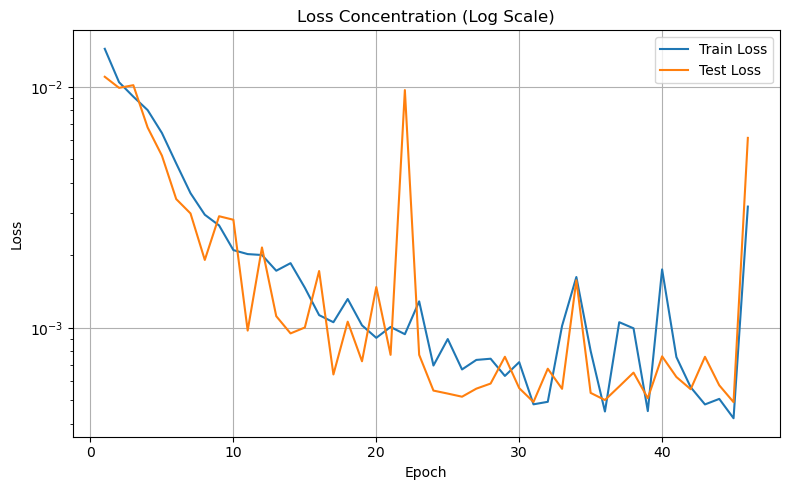

In [11]:
epochs = range(1, len(train_losses) + 1)
plt.figure(figsize=(8,5))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, test_losses,  label='Test Loss')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Concentration (Log Scale)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("con_loss_log.svg", format="svg")
plt.show()


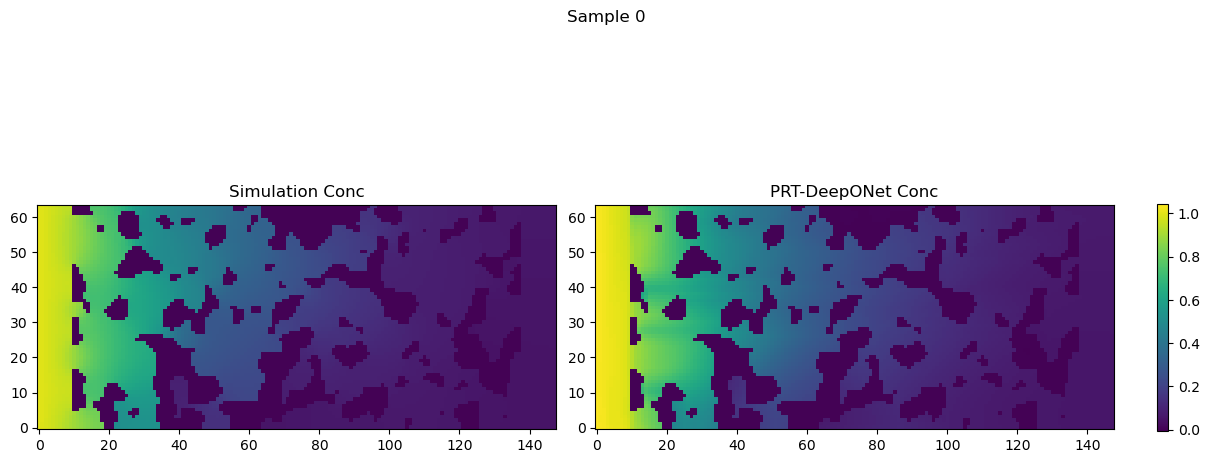

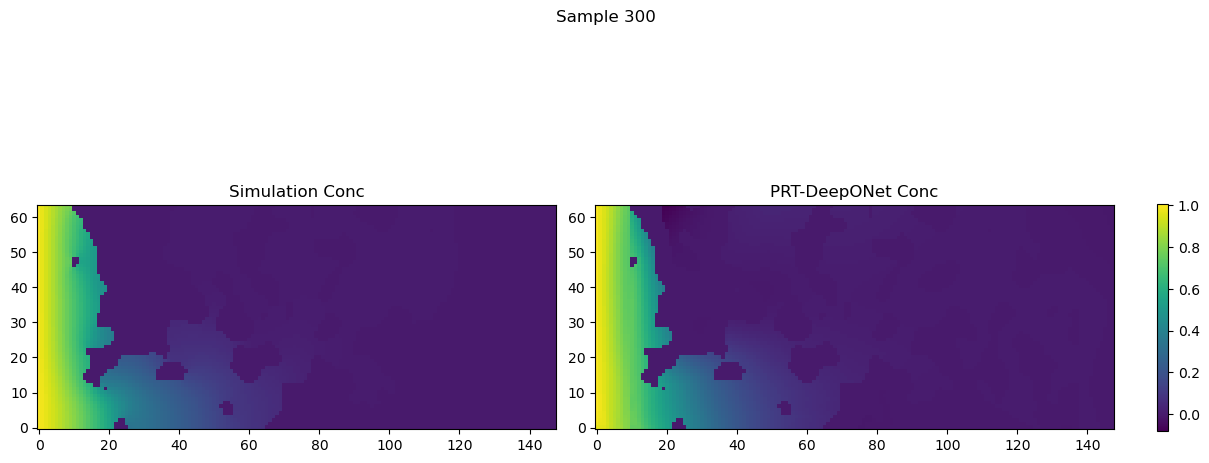

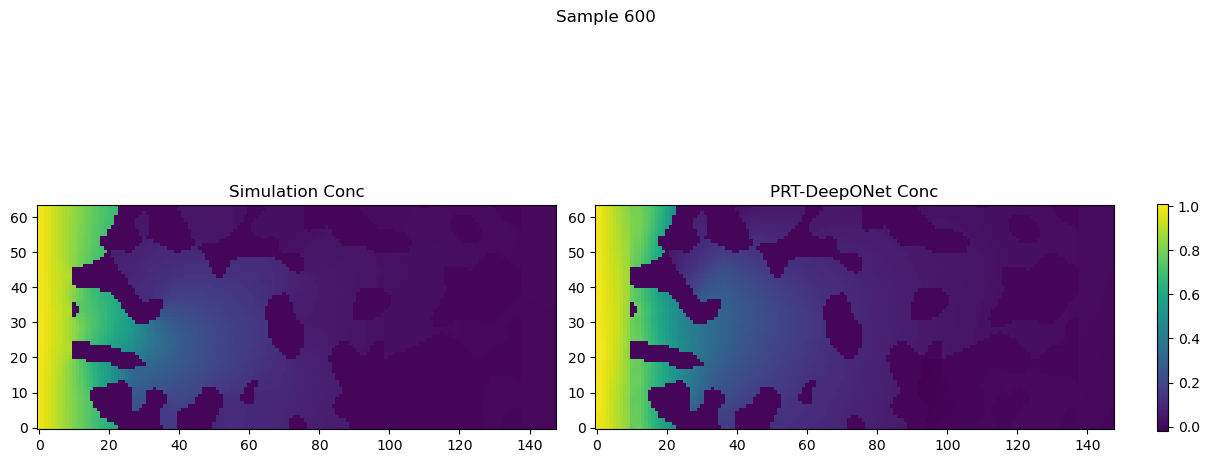

In [12]:
sample_indices = [0, 300, 600]
for idx in sample_indices:
    visualize_results_concentration_corrected(
        model, 
        test_branch1_tensor,  # branch1 (마스크 이미지)
        test_branch2_tensor,  # branch2 (Da)
        test_trunk_tensor,    # trunk ([x, y, sdf])
        test_target_tensor,   # target (농도)
        sample_idx=idx,
        save_svg=f"concentration_sample_{idx}.svg"
    )


In [13]:
def visualize_conc_and_error_for_samples(
    model,
    branch1_tensor,
    branch2_tensor,
    trunk_tensor,
    target_tensor,
    test_domains,
    sample_indices,
    save_prefix=None,
    cmap_conc='viridis',
    cmap_err='viridis'
):
    """
    여러 샘플에 대해 농도(actual, predicted)와 절대 오차를 heatmap으로 그립니다.
    - 행: sample_indices 순서
    - 열: 0=Actual Conc, 1=Predicted Conc, 2=Absolute Error
    - 왼쪽에 각 행마다 ‘Da = <orig_Da>’ 레이블
    - 맨 아래에 가로형 컬러바 2개: 왼쪽은 농도, 오른쪽은 오차
    """
    def get_orig_Da(domain_num):
        if 1 <= domain_num <= 3000:   return 0.5
        if 3001 <= domain_num <= 6000: return 5.0
        return 2.0

    # 1) 전체 스케일 계산
    concs, errs = [], []
    for idx in sample_indices:
        preds, actual = evaluate_sample_concentration(
            model, branch1_tensor, branch2_tensor, trunk_tensor, target_tensor, sample_idx=idx
        )
        mask   = branch1_tensor[idx].cpu().numpy()[0]
        p_corr = apply_candidate_correction(preds,  mask)
        a_corr = apply_candidate_correction(actual, mask)
        concs += [a_corr.flatten(), p_corr.flatten()]
        errs.append(np.abs(p_corr - a_corr).flatten())

    conc_all = np.concatenate(concs)
    err_all  = np.concatenate(errs)
    vmin_c, vmax_c = conc_all.min(), conc_all.max()
    vmin_e, vmax_e = err_all.min(),  err_all.max()

    # 2) 플롯 영역 준비
    n = len(sample_indices)
    fig, axes = plt.subplots(n, 3, figsize=(12, 8), constrained_layout=False)
    plt.subplots_adjust(left=0.15, right=0.95, top=0.95, bottom=0.12,
                        hspace=0.3, wspace=0.1)

    # 3) 각 행(row)에 Actual/Predicted/Error 그리고 Da 레이블
    for row, idx in enumerate(sample_indices):
        preds, actual = evaluate_sample_concentration(
            model, branch1_tensor, branch2_tensor, trunk_tensor, target_tensor, sample_idx=idx
        )
        mask   = branch1_tensor[idx].cpu().numpy()[0]
        p_corr = apply_candidate_correction(preds,  mask)
        a_corr = apply_candidate_correction(actual, mask)
        err    = np.abs(p_corr - a_corr)

        # 왼쪽에 orig_Da 표시
        domain_num = test_domains[idx]['domain_num']
        da_val = int(get_orig_Da(domain_num) * 148)
        pos = axes[row, 0].get_position()
        y = pos.y0 + pos.height / 2
        fig.text(0.05, y, f"Da = {da_val}", va='center', ha='left', fontsize=12)

        # Actual Conc
        im0 = axes[row, 0].imshow(
            a_corr.squeeze(),
            vmin=vmin_c, vmax=vmax_c,
            cmap=cmap_conc, origin='lower'
        )
        axes[row, 0].set_title("Simulation")
        axes[row, 0].axis('off')

        # Predicted Conc
        im1 = axes[row, 1].imshow(
            p_corr.squeeze(),
            vmin=vmin_c, vmax=vmax_c,
            cmap=cmap_conc, origin='lower'
        )
        axes[row, 1].set_title("PRT-DeepONet")
        axes[row, 1].axis('off')

        # Absolute Error
        im2 = axes[row, 2].imshow(
            err.squeeze(),
            vmin=vmin_e, vmax=vmax_e,
            cmap=cmap_err, origin='lower'
        )
        axes[row, 2].set_title("Abs Error")
        axes[row, 2].axis('off')

    # 4) 맨 아래 가로 컬러바 2개
    cax_c = fig.add_axes([0.15, 0.05, 0.525, 0.01])
    fig.colorbar(im0, cax=cax_c, orientation='horizontal')
    cax_e = fig.add_axes([0.70, 0.05, 0.248, 0.01])
    fig.colorbar(im2, cax=cax_e, orientation='horizontal')

    # 5) 저장 및 표시
    if save_prefix:
        plt.savefig(f"{save_prefix}.svg", format='svg')
    plt.show()

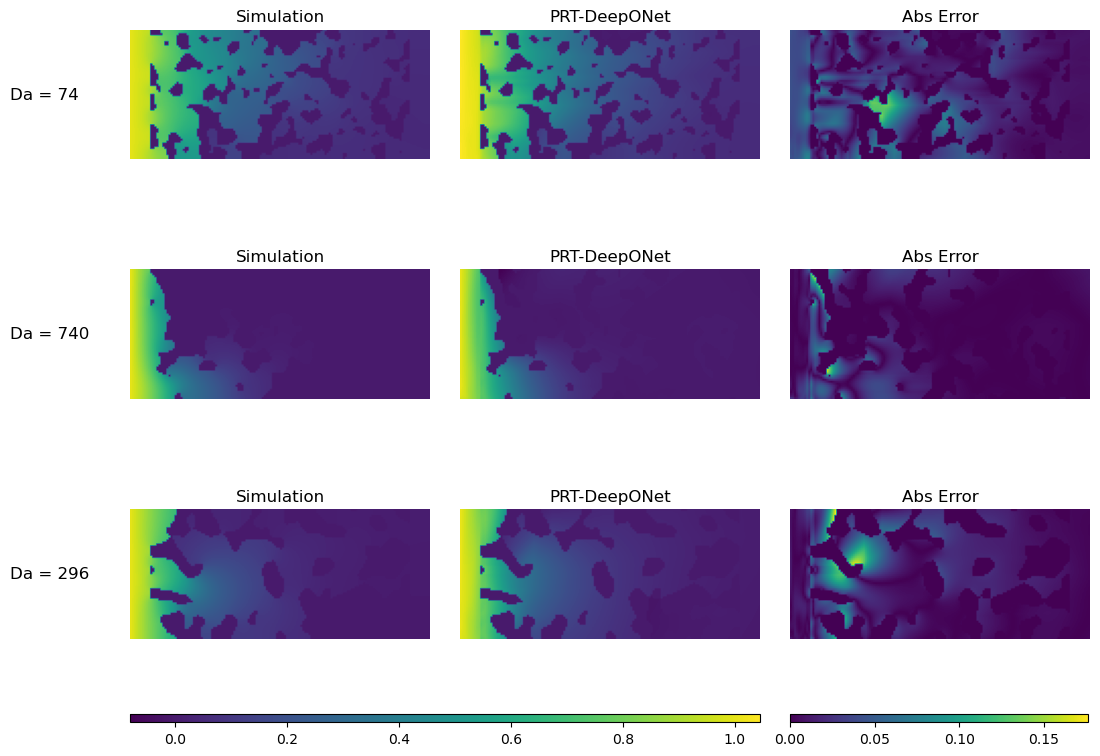

In [14]:
sample_indices = [0, 300, 600]
visualize_conc_and_error_for_samples(
    model,
    test_branch1_tensor,    # branch1: image mask
    test_branch2_tensor,    # branch2: Da
    test_trunk_tensor,      # trunk: [x,y,sdf]
    test_target_tensor,     # target
    test_domains,
    sample_indices,
    save_prefix="conc_Da"
)

In [15]:
torch.save(model.state_dict(), "con_steady_model_weights.pth")
torch.save(model, "con_steady_model_full.pth")


In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


errors = []
for idx in range(len(test_branch1_tensor)):
    # 예측 및 실제값 (정규화 해제 불필요/이미 비정규화면 그대로)
    preds = model(
        test_branch1_tensor[idx:idx+1].to(device),
        test_branch2_tensor[idx:idx+1].to(device),
        test_trunk_tensor[idx:idx+1].to(device)
    ).cpu().detach().numpy()[0]        # ← detach() 추가!
    actual = test_target_tensor[idx].cpu().numpy()
    # 마스크 추출
    mask = test_branch1_tensor[idx, 0].cpu().numpy()
    # NRMSE 계산
    _, nrmse = compute_mape_nrmse_concentration_corrected(preds, actual, mask)
    errors.append(nrmse)

errors = np.array(errors)
best_idx = int(np.argmin(errors))
best_domain = test_domains[best_idx]['domain_num']
best_nrmse = errors[best_idx]

print(f"가장 오차가 작은 테스트 인덱스: {best_idx}")
print(f"해당 도메인 번호         : {best_domain}")
print(f"최소 NRMSE 값           : {best_nrmse:.4f}")


가장 오차가 작은 테스트 인덱스: 418
해당 도메인 번호         : 4637
최소 NRMSE 값           : 0.0128


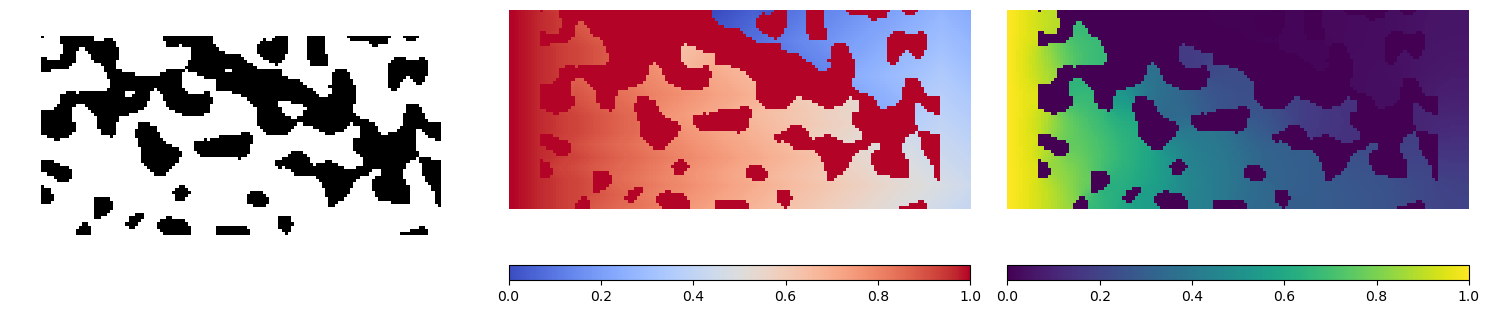

In [23]:
test_idx = 100

mask_img = test_branch1_tensor[test_idx, 0].cpu().numpy()     

# SDF 정규화된 값 그대로 사용!
sdf_norm_flat = test_trunk_tensor[test_idx, 0, :, 2].cpu().numpy()
sdf_img = sdf_norm_flat.reshape(mask_img.shape)   # 정규화 복원 없이!

conc_img = test_target_tensor[test_idx].cpu().numpy().squeeze()

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].imshow(mask_img, cmap='gray')
axes[0].axis('off')

im1 = axes[1].imshow(sdf_img,cmap='coolwarm')
axes[1].axis('off')
# 가로 컬러바
cbar1 = plt.colorbar(im1, ax=axes[1], orientation='horizontal', shrink=1, pad=0.15, aspect=30)

im2 = axes[2].imshow(conc_img, cmap='viridis')
axes[2].axis('off')
cbar2 = plt.colorbar(im2, ax=axes[2], orientation='horizontal', shrink=1, pad=0.15, aspect=30)

plt.tight_layout()
plt.savefig("DON_c.svg", format="svg")
plt.show()


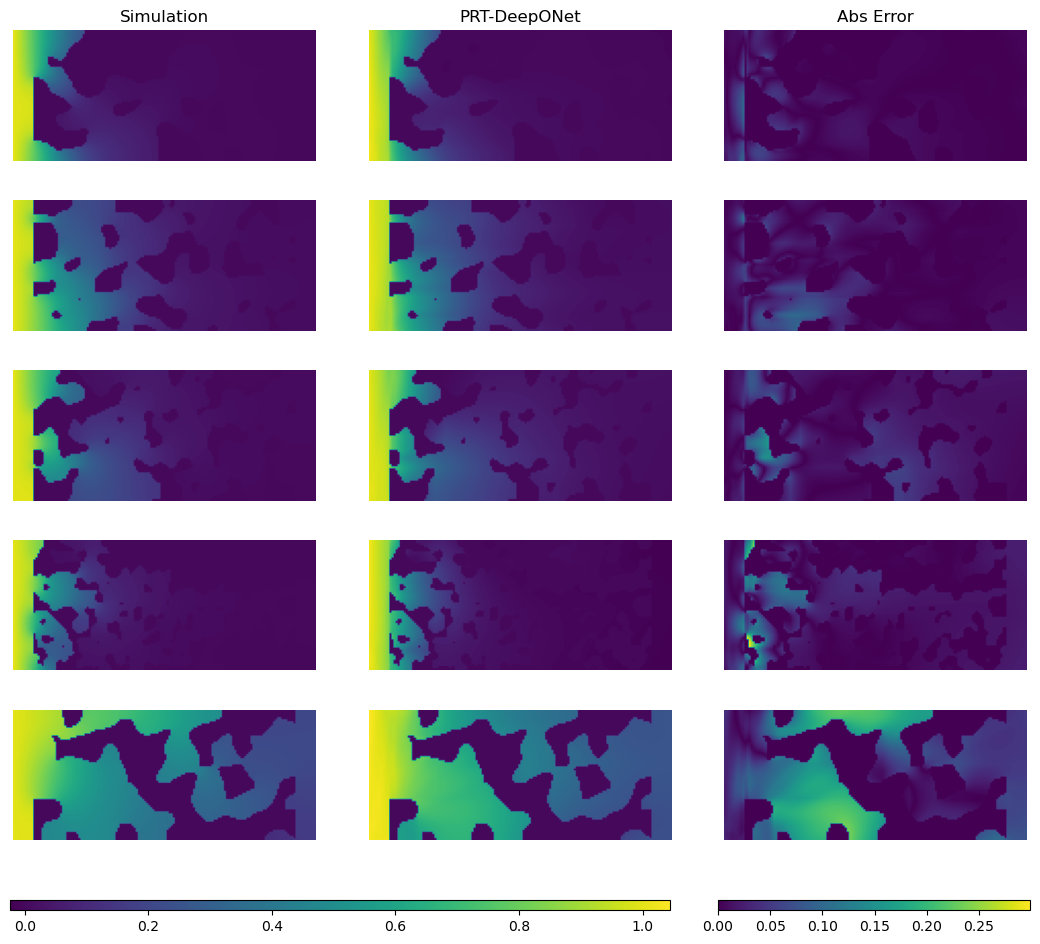

In [18]:
# 1) 수정된 evaluate_sample_concentration 함수
def evaluate_sample_concentration(model,
                                  branch1_tensor,
                                  branch2_tensor,
                                  trunk_tensor,
                                  target_tensor,
                                  sample_idx):
    """
    sample_idx에 대해
     - preds: (nx,ny,1) raw 예측
     - actual: (nx,ny,1) raw 실제
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device).eval()

    with torch.no_grad():
        sb1 = branch1_tensor[sample_idx:sample_idx+1].to(device)  # mask
        sb2 = branch2_tensor[sample_idx:sample_idx+1].to(device)  # Da
        st  = trunk_tensor[sample_idx:sample_idx+1].to(device)    # (1, L, 3)
        preds  = model(sb1, sb2, st).cpu().numpy()[0]             # (nx,ny,1)
        actual = target_tensor[sample_idx].cpu().numpy()          # (nx,ny,1)

    return preds, actual


# 2) 5×3 그리드용 호출부 전체 예시
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# (a) NRMSE 리스트
nrmse_list = []
num_samples = len(test_branch1_tensor)
for idx in range(num_samples):
    preds, actual = evaluate_sample_concentration(
        model,
        test_branch1_tensor,
        test_branch2_tensor,
        test_trunk_tensor,
        test_target_tensor,
        sample_idx=idx
    )
    mask = test_branch1_tensor[idx].cpu().numpy()[0]
    _, nrmse = compute_mape_nrmse_concentration_corrected(preds, actual, mask)
    nrmse_list.append(nrmse)

# (b) Percentile 인덱스
nrmse_arr = np.array(nrmse_list)
best_idx  = nrmse_arr.argmin()
worst_idx = nrmse_arr.argmax()
sorted_idx = np.argsort(nrmse_arr)
idx25 = sorted_idx[int(len(sorted_idx)*0.25)]
idx50 = sorted_idx[int(len(sorted_idx)*0.50)]
idx75 = sorted_idx[int(len(sorted_idx)*0.75)]
sample_indices = [best_idx, idx25, idx50, idx75, worst_idx]
row_labels     = ["Best", "25%", "50%", "75%", "Worst"]

# (c) 전역 vmin/vmax 계산
conc_vals, err_vals = [], []
for idx in sample_indices:
    preds, actual = evaluate_sample_concentration(
        model,
        test_branch1_tensor,
        test_branch2_tensor,
        test_trunk_tensor,
        test_target_tensor,
        sample_idx=idx
    )
    mask = test_branch1_tensor[idx].cpu().numpy()[0]
    p_corr = apply_candidate_correction(preds, mask)
    a_corr = apply_candidate_correction(actual, mask)
    conc_vals.extend([a_corr.flatten(), p_corr.flatten()])
    err_vals.append(np.abs(p_corr - a_corr).flatten())

conc_all    = np.concatenate(conc_vals)
err_all     = np.concatenate(err_vals)
vmin_conc, vmax_conc = conc_all.min(), conc_all.max()
vmin_err,  vmax_err  = err_all.min(),  err_all.max()

# (d) 5×3 그리드 그리기
fig, axes = plt.subplots(5, 3, figsize=(12,10))
plt.subplots_adjust(top=0.93, bottom=0.12, left=0.10, right=0.95,
                    hspace=0.3, wspace=0.15)

for row, idx in enumerate(sample_indices):
    preds, actual = evaluate_sample_concentration(
        model,
        test_branch1_tensor,
        test_branch2_tensor,
        test_trunk_tensor,
        test_target_tensor,
        sample_idx=idx
    )
    mask       = test_branch1_tensor[idx].cpu().numpy()[0]
    p_corr     = apply_candidate_correction(preds, mask)
    a_corr     = apply_candidate_correction(actual, mask)
    abs_error  = np.abs(p_corr - a_corr)

    # Simulation (Actual)
    ax0 = axes[row, 0]
    im0 = ax0.imshow(a_corr.squeeze(), vmin=vmin_conc, vmax=vmax_conc, cmap='viridis', origin='lower')
    ax0.set_ylabel(row_labels[row], rotation=0, labelpad=40, va='center')
    if row == 0: ax0.set_title("Simulation")
    ax0.axis('off')

    # PRT-DeepONet (Predicted)
    ax1 = axes[row, 1]
    im1 = ax1.imshow(p_corr.squeeze(),   vmin=vmin_conc, vmax=vmax_conc, cmap='viridis', origin='lower')
    if row == 0: ax1.set_title("PRT-DeepONet")
    ax1.axis('off')

    # Abs Error
    ax2 = axes[row, 2]
    im2 = ax2.imshow(abs_error.squeeze(), vmin=vmin_err, vmax=vmax_err, cmap='viridis', origin='lower')
    if row == 0: ax2.set_title("Abs Error")
    ax2.axis('off')

# (e) 하단 컬러바
cbar_ax1 = fig.add_axes([0.1, 0.05, 0.55, 0.01])
fig.colorbar(im0, cax=cbar_ax1, orientation='horizontal')
cbar_ax2 = fig.add_axes([0.69, 0.05, 0.26, 0.01])
fig.colorbar(im2, cax=cbar_ax2, orientation='horizontal')

plt.savefig("conc_per_Da.svg", format="svg")
plt.show()

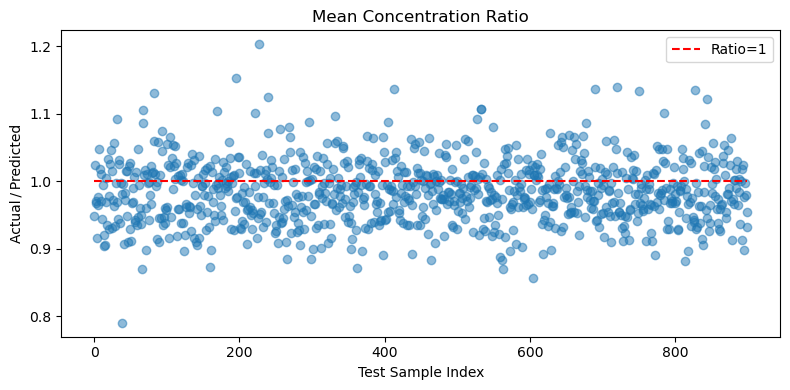

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()
num_samples = len(test_branch1_tensor)

# 1) 농도장 비율 계산
conc_ratio = []
for idx in range(num_samples):
    # preds, actual은 이미 (nx, ny, 1) 배열
    preds, actual = evaluate_sample_concentration(
        model,
        test_branch1_tensor,
        test_branch2_tensor,
        test_trunk_tensor,
        test_target_tensor,
        sample_idx=idx
    )
    mask = test_branch1_tensor[idx].cpu().numpy()[0]

    # 후보정 후 평균 추출
    preds_corr  = apply_candidate_correction(preds, mask)
    actual_corr = apply_candidate_correction(actual, mask)
    mean_pred   = preds_corr.mean()
    mean_actual = actual_corr.mean()

    conc_ratio.append(mean_actual / mean_pred if mean_pred != 0 else np.nan)

# 2) 시각화
plt.figure(figsize=(8,4))
plt.scatter(np.arange(num_samples), conc_ratio, alpha=0.5)
plt.hlines(1, 0, num_samples-1, linestyles='--', color='red', label='Ratio=1')
plt.xlabel("Test Sample Index")
plt.ylabel("Actual / Predicted")
plt.title("Mean Concentration Ratio")
plt.legend()
plt.tight_layout()
plt.savefig("con_ratio.svg", format="svg")
plt.show()
